# Compute and plot tide from OTPS2 (TPXO8) fortran code

In [1]:
%matplotlib notebook

In [35]:
import numpy as np
import datetime
import pandas
import urllib2, urllib
from pytides.tide import Tide
from subprocess import call
import os

In [3]:
#define point of measurement

In [4]:
point=1306

In [5]:
#start date
tstamp='20160601.000'
t=datetime.datetime.strptime(tstamp,"%Y%m%d.%H%M%S")

In [6]:
#end day
estamp='20160630.000'
ed=datetime.datetime.strptime(estamp,"%Y%m%d.%H%M%S")

## READ tide gauge measurements

In [7]:
url='http://webcritech.jrc.ec.europa.eu/SeaLevelsDb/Home/ShowBuoyData?id={}&dateMin={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&dateMax={}%2F{:02d}%2F{:02d}+{:02d}%3A{:02d}&field=&options='\
                                 .format(point,t.year,t.month,t.day,t.hour,0,ed.year,ed.month,ed.day,ed.hour,0)


In [8]:
response=urllib2.urlopen(url)
ls=response.readlines()
lp=[elem.strip().split(',')  for elem in ls]

# get lat lon
c=[a.split(' ') for a in lp[1]][0]
if 'lat' in c[2]: 
           plat=c[2].split('=')[1]
           idt=6
else:
           c=[a.split(' ') for a in lp[2]][0]
           if 'lat' in c[2]: plat=c[2].split('=')[1]
           idt=7

if 'lon' in c[3]: plon=c[3].split('=')[1]



In [9]:
print plon, plat

-0.150 39.000


In [10]:
rt=[]
vt=[]
for a,b,c,d in lp[idt:]:
    rt.append(datetime.datetime.strptime(a,'%d %b %Y %H:%M:%S'))
    vt.append(c) # tide column

In [11]:
d=np.array([rt,vt]).T

In [12]:
dat1=pandas.DataFrame(d,columns=['time','elev'])

In [13]:
dat1=dat1.set_index(['time'])

In [14]:
dat1['elev']=pandas.to_numeric(dat1['elev']) # convert string to floats

In [15]:
ax1=dat1.plot(figsize=(12,4))
ax1.set_ylabel('h')

<IPython.core.display.Javascript object>

## Compute constituents from measurements

In [16]:
demeaned=dat1['elev'].values-dat1['elev'].values.mean()

In [17]:
tide=Tide.decompose(demeaned, dat1['elev'].index)

In [18]:
constituent = [c.name for c in tide.model['constituent']]

In [19]:
df=pandas.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

In [20]:
df.sort_values(by='amplitude', ascending=False).head(10)

,amplitude,phase
S1,1.338092,100.530548
S2,1.024371,285.684256
T2,0.763080,301.244941
K1,0.714224,269.208553
P1,0.695304,285.703223
L2,0.336430,12.098329
lambda2,0.286409,96.822281
R2,0.215357,109.968758
K2,0.168596,249.403787
nu2,0.156430,123.734522


### Setup the fortan files

In [21]:
path='../TIDES/OTPS2/'

In [22]:
# location
#plon=-5.72
#plat=36.

In [23]:
#dt
delta=datetime.timedelta(hours=1)

In [24]:
with open(path+'lat_lon_time1','w') as f:
    while t <= ed: 
     f.write('{}  {}  {}  {}  {}  {}  {}  {}\n'.format(plat,plon,t.year,t.month,t.day,t.hour,t.minute, t.second))
     t += delta

## Evaluate Constituents (TPX08)

In [39]:
os.chdir(path)

In [41]:
! ./extract_HC < setup.inp

 DATA/Model_atlas_v1
 Lat/Lon file:lat_lon_time1
 Extract OCEAN tide HC
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Output elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011             
 Loading local solution elevations Med2011             
 Results are in sample1.out
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [43]:
cst=pandas.read_csv('sample1.out',skiprows=[0,1,3],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [44]:
cst

,Lat,Lon,m2_amp,m2_ph,s2_amp,s2_ph,n2_amp,n2_ph,k2_amp,k2_ph,...,m4_amp,m4_ph,ms4_amp,ms4_ph,mn4_amp,mn4_ph,mm_amp,mm_ph,mf_amp,mf_ph
0,39,-0.15,0.015,-137.3,0.004,-116.6,0.004,-157.2,0.001,-123.6,...,0.001,-10.9,0,46.9,0.001,-72.6,0.001,-150.9,0.002,-171.6


In [45]:
cst.drop(['Lat','Lon'], axis=1)

,m2_amp,m2_ph,s2_amp,s2_ph,n2_amp,n2_ph,k2_amp,k2_ph,k1_amp,k1_ph,...,m4_amp,m4_ph,ms4_amp,ms4_ph,mn4_amp,mn4_ph,mm_amp,mm_ph,mf_amp,mf_ph
0,0.015,-137.3,0.004,-116.6,0.004,-157.2,0.001,-123.6,0.038,163.5,...,0.001,-10.9,0,46.9,0.001,-72.6,0.001,-150.9,0.002,-171.6


## Predict tide (TPX08)

In [46]:
! ./predict_tide < setup.inp

 DATA/Model_atlas_v1
 Lat/Lon/Time file:lat_lon_time1
 Predict OCEAN tide
 Interpolate minor constituents
 Model type: atlas (combined of several models)
 Models in atlas:          30
 Lat limits:     -90.0833359       90.0833359    
 Lon limits:      8.33384171E-02   360.083344    
 Predict elevations (m)
 Constituents: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Constituents to include: m2  s2  n2  k2  k1  o1  p1  q1  m4  ms4 mn4 mm  mf  
 Loading local solution grid Med2011
 Loading local solution elevations Med2011             
 Results are in sample1.out
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [47]:
data=pandas.read_csv('sample1.out',skiprows=[0,1,2,3,6],delim_whitespace=True, skipinitialspace=True)#, index_col=['mm.dd.yyyy','hh:mm:ss'] )

In [48]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m)
0,39,-0.15,06.01.2016,00:00:00,0.017,5


In [49]:
#merge columns for date
data['time']=data['mm.dd.yyyy'].astype(str).str.cat(data['hh:mm:ss'].astype(str), sep='.')

In [50]:
#print first row for verification
data[:1]

,Lat,Lon,mm.dd.yyyy,hh:mm:ss,z(m),Depth(m),time
0,39,-0.15,06.01.2016,00:00:00,0.017,5,06.01.2016.00:00:00


In [51]:
#Delete unwanted columns
dat = data.drop(['Lat','Lon','Depth(m)','mm.dd.yyyy', 'hh:mm:ss'], axis=1)

In [52]:
#set time as index
dat=dat.set_index(['time'])

In [53]:
#h=pandas.Series(dat['z(m)'])

In [54]:
dat.index=pandas.to_datetime(dat.index)

<IPython.core.display.Javascript object>


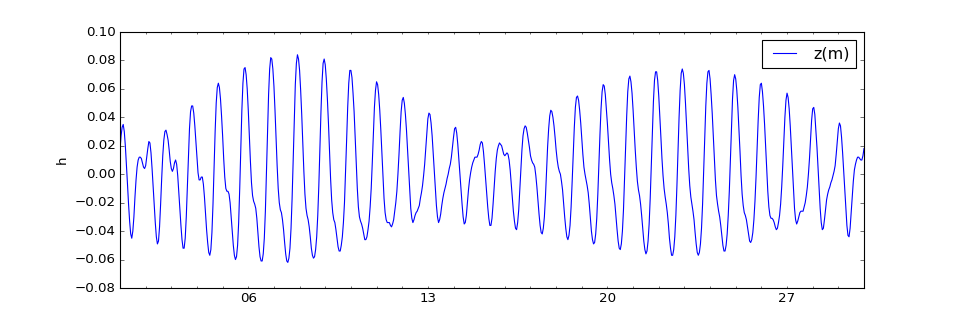

In [55]:
ax=dat.plot(figsize=(12,4))
ax.set_ylabel('h')


In [56]:
#put together
add2=dat1.join(dat,how='inner')

<IPython.core.display.Javascript object>


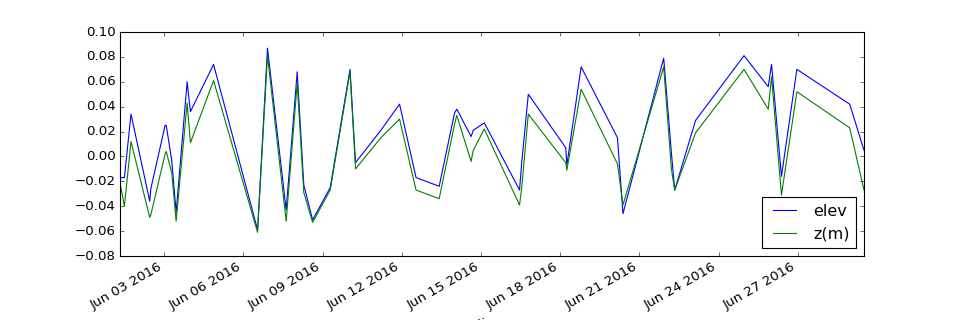

In [57]:
add2.plot(x=add2.index,y=['elev','z(m)'], figsize=(12,4))

<IPython.core.display.Javascript object>


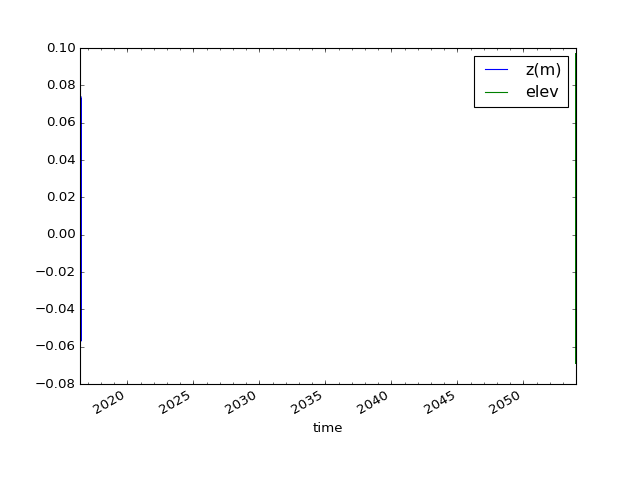

In [58]:
ax3=dat.plot()
dat1.plot(ax=ax3)